In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import scipy
import os
import time

import keras
from keras.optimizers import Adadelta
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

from sklearn.metrics import confusion_matrix
from matplotlib import animation, rc
import matplotlib.patches as mpatches
from IPython.display import HTML
from IPython.display import display, clear_output
import ipywidgets as widgets
#%matplotlib notebook

In [2]:
# my GPU has little ram, so we're just gonna use the CPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import warnings
warnings.filterwarnings("ignore")

if not os.path.exists('models'):
    os.makedirs('models')

# Data Processing

In [3]:
classes = os.listdir('by_class')

data_pairs = []
for class_int, class_dir in enumerate(classes):
    image_path = 'by_class/{}/train_{}/'.format(class_dir, class_dir)
    image_files = os.listdir(image_path)
    for d in [image_path + img for img in image_files]:
        data_pairs.append((d, class_int))
        
x_data = np.array(data_pairs)[::,0]
y_data = keras.utils.to_categorical(np.array(data_pairs)[::,1], len(classes))

In [4]:
full_idx = np.arange(0, len(x_data))
train_idx = np.random.choice(full_idx, 
                             int(len(x_data)*0.8), 
                             replace=False)
test_idx = np.setdiff1d(full_idx, train_idx)

x_train = x_data[train_idx]
y_train = y_data[train_idx]
x_test = x_data[test_idx]
y_test = y_data[test_idx]

50


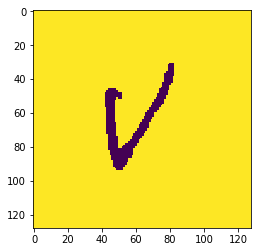

In [5]:
try:
    im = imageio.imread(data_pairs[591000][0], pilmode='L')/255
except TypeError as e:
    im = scipy.misc.imread(data_pairs[591000][0], mode='L')/255
print(data_pairs[590000][1])
plt.imshow(im)

In [6]:
def batch_generator(x, y, batch_size=32, iterate=False):
    count = 0
    while True:
        idx = np.random.randint(0, len(x), batch_size)
        if iterate:
            idx = np.arange(count*batch, (count+1)*batch)
            if idx[-1] > len(x):
                yield np.array([]), np.array([])
        im_files = x[idx]
        ims = []
        labels = y[idx]
        
        for i in im_files:
            try:
                image = imageio.imread(i, pilmode='L')/255
            except TypeError as e:
                image = scipy.misc.imread(i, mode='L')/255
            image = np.expand_dims(image, axis=0)
            ims.append(image)

        yield np.array(ims), labels

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
32


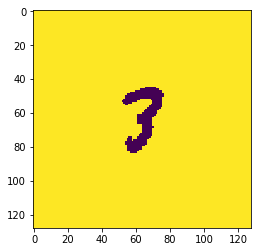

In [7]:
# quick test
for gen, label in batch_generator(x_train, y_train):
    for im, l in zip(gen, label):
        print(l)
        print(np.argmax(l))
        plt.imshow(im.reshape(128,128))
        plt.show()
        break
    break

# Model

In [8]:
img_rows, img_cols = 128, 128
input_shape = (1, img_rows, img_cols)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,
                 data_format="channels_first"))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

adadelta = Adadelta(lr=0.1)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['categorical_accuracy'])

# Training

In [ ]:
callback_list = []
train_name = str(int(time.time()))
if not os.path.exists('models/' + train_name):
    os.makedirs('models/' + train_name)
callback_list.append(EarlyStopping(monitor='val_loss', patience=100))
callback_list.append(TensorBoard(log_dir='./logs/' + train_name))
model_path="models/" + str(int(time.time())) +"/model_{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
callback_list.append(ModelCheckpoint(model_path, monitor='val_categorical_accuracy', period=10))

train_gen = batch_generator(x_train, y_train, batch_size=32)
test_gen = batch_generator(x_test, y_test, batch_size=32)

hist = model.fit_generator(generator=train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=8,
                    validation_steps=8,
                    epochs=1000,
                    verbose=1,
                    callbacks=callback_list)

Epoch 1/1000
8/8 [==============================] - 32s 4s/step - loss: 3.7911 - categorical_accuracy: 0.1406 - val_loss: 3.5062 - val_categorical_accuracy: 0.1523
Epoch 2/1000
8/8 [==============================] - 31s 4s/step - loss: 3.5319 - categorical_accuracy: 0.1914 - val_loss: 3.3885 - val_categorical_accuracy: 0.2227
Epoch 3/1000
8/8 [==============================] - 31s 4s/step - loss: 3.5539 - categorical_accuracy: 0.1484 - val_loss: 3.2070 - val_categorical_accuracy: 0.2734
Epoch 4/1000
8/8 [==============================] - 31s 4s/step - loss: 3.3925 - categorical_accuracy: 0.1992 - val_loss: 3.2095 - val_categorical_accuracy: 0.2578
Epoch 5/1000
8/8 [==============================] - 31s 4s/step - loss: 3.4824 - categorical_accuracy: 0.1367 - val_loss: 3.0349 - val_categorical_accuracy: 0.3242
Epoch 6/1000
8/8 [==============================] - 31s 4s/step - loss: 3.5290 - categorical_accuracy: 0.1875 - val_loss: 3.1912 - val_categorical_accuracy: 0.3320
Epoch 7/1000
8/8

Epoch 51/1000
8/8 [==============================] - 31s 4s/step - loss: 2.4593 - categorical_accuracy: 0.3672 - val_loss: 1.9212 - val_categorical_accuracy: 0.5859
Epoch 52/1000
8/8 [==============================] - 32s 4s/step - loss: 2.3630 - categorical_accuracy: 0.4062 - val_loss: 1.7886 - val_categorical_accuracy: 0.5977
Epoch 53/1000
8/8 [==============================] - 31s 4s/step - loss: 2.4001 - categorical_accuracy: 0.4414 - val_loss: 1.8674 - val_categorical_accuracy: 0.5586
Epoch 54/1000
8/8 [==============================] - 31s 4s/step - loss: 2.3047 - categorical_accuracy: 0.4531 - val_loss: 1.8133 - val_categorical_accuracy: 0.5117
Epoch 55/1000
8/8 [==============================] - 31s 4s/step - loss: 2.3261 - categorical_accuracy: 0.4336 - val_loss: 1.8986 - val_categorical_accuracy: 0.5312
Epoch 56/1000
8/8 [==============================] - 31s 4s/step - loss: 2.3312 - categorical_accuracy: 0.4570 - val_loss: 2.0308 - val_categorical_accuracy: 0.5156
Epoch 57/1

8/8 [==============================] - 31s 4s/step - loss: 1.6210 - categorical_accuracy: 0.5781 - val_loss: 1.3181 - val_categorical_accuracy: 0.6289
Epoch 150/1000
8/8 [==============================] - 31s 4s/step - loss: 1.5707 - categorical_accuracy: 0.5820 - val_loss: 1.1462 - val_categorical_accuracy: 0.6992
Epoch 151/1000
8/8 [==============================] - 31s 4s/step - loss: 1.8616 - categorical_accuracy: 0.5352 - val_loss: 1.1939 - val_categorical_accuracy: 0.6641
Epoch 152/1000
8/8 [==============================] - 32s 4s/step - loss: 1.6989 - categorical_accuracy: 0.5938 - val_loss: 1.0723 - val_categorical_accuracy: 0.7031
Epoch 153/1000
8/8 [==============================] - 32s 4s/step - loss: 1.6533 - categorical_accuracy: 0.5352 - val_loss: 1.1353 - val_categorical_accuracy: 0.6797
Epoch 154/1000
8/8 [==============================] - 31s 4s/step - loss: 1.6278 - categorical_accuracy: 0.5312 - val_loss: 0.9502 - val_categorical_accuracy: 0.7344
Epoch 155/1000
8/8 

# Evaluation

In [11]:
try:
    model
except NameError as e:
    print("Loading saved model...")
    model = load_model('models/model.hdf5')

Loading saved model...


In [12]:
df = pd.DataFrame(hist.history)
df.plot(figsize=(10,8))

NameError: name 'hist' is not defined

In [15]:
test_gen = batch_generator(x_test, y_test, batch_size=32)
score = model.evaluate_generator(test_gen, steps=10)
print('Test loss:', score[0])
print('Test categorical accuracy:', score[1])

Test loss: 1.1980380237102508
Test categorical accuracy: 0.703125


In [16]:
for x, y in test_gen:
    pred = model.predict(x)
    for xp, l in zip(pred, y):
        print("Predicition:", np.argmax(xp))
        print("Actual     :", np.argmax(l))
        print("----------------------")
    break

Predicition: 35
Actual     : 36
----------------------
Predicition: 39
Actual     : 39
----------------------
Predicition: 28
Actual     : 56
----------------------
Predicition: 58
Actual     : 58
----------------------
Predicition: 28
Actual     : 28
----------------------
Predicition: 32
Actual     : 32
----------------------
Predicition: 15
Actual     : 15
----------------------
Predicition: 58
Actual     : 58
----------------------
Predicition: 15
Actual     : 15
----------------------
Predicition: 3
Actual     : 3
----------------------
Predicition: 6
Actual     : 6
----------------------
Predicition: 53
Actual     : 44
----------------------
Predicition: 22
Actual     : 22
----------------------
Predicition: 58
Actual     : 58
----------------------
Predicition: 28
Actual     : 2
----------------------
Predicition: 37
Actual     : 50
----------------------
Predicition: 38
Actual     : 33
----------------------
Predicition: 28
Actual     : 51
----------------------
Predicition: 6


# Confusion Matrix

In [17]:
all_gen = batch_generator(x_test, y_test, batch_size = 100)
y_true = np.array([])
y_pred = np.array([])

for x, y in all_gen:
    if not y_true.size:
        y_true = y_true.reshape((0, y.shape[1]))
        y_pred = y_true.reshape((0, y.shape[1]))

    y_true = np.concatenate((y_true, y))
    
    _y = model.predict(x)
    y_pred = np.concatenate((y_pred, _y))
    
    if len(y_true) == 1000:
        break

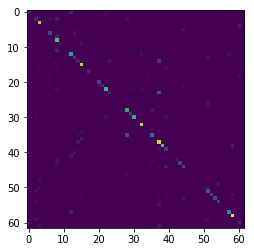

In [18]:
cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
plt.imshow(cm)

# Tensorboard Results

In [ ]:
df_loss = pd.read_csv('run_1536441301-tag-loss.csv')
df_val_loss = pd.read_csv('run_1536441301-tag-val_loss.csv')

plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Categorical Crossentropy")

plt.legend(handles=[
    mpatches.Patch(color='C0', label='Training Loss'),
    mpatches.Patch(color='C1', label='Validation Loss')
])

plt.plot(df_loss.Step, df_loss.Value)
plt.plot(df_val_loss.Step, df_val_loss.Value)

In [ ]:
df_loss = pd.read_csv('run_1536441301-tag-categorical_accuracy.csv')
df_val_loss = pd.read_csv('run_1536441301-tag-val_categorical_accuracy.csv')

plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")

plt.legend(handles=[
    mpatches.Patch(color='C0', label='Training Accuracy'),
    mpatches.Patch(color='C1', label='Validation Accuracy')
])

plt.plot(df_loss.Step, df_loss.Value)
plt.plot(df_val_loss.Step, df_val_loss.Value)